In [58]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner_v3")


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict

from utils.quadratic import Quadratic, Quadratic2D, SimpleQuadratic
from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.rnn_optimizer import kl_divergence
from models.layer_norm_lstm import LayerNormLSTMCell
from utils.utils import Experiment, get_model, create_def_argparser, get_experiment, create_logger
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, create_x_val_array, plot_kl_div_parts
from utils.plots import get_exper_loss_data, plot_val_result, plot_exper_losses, plot_parm_loss_steps
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
expers_to_load = [(False, "run_20170515_16_39_42_metaV1_15ep_5ops_lr5e05_adam"),
                  (False, "run_20170511_11_19_11_metaV1_20ep_3ops_lr5e05_adam"),
                  (False, "run_20170511_11_20_11_metaV1_20ep_2ops_lr5e05_adam"),
                  # META V2 model (trained with T samples)
                  (False, "run_20170515_17_25_23_metaV2_15ep_5ops_lr5e05_adam"),
                  (False, "run_20170511_11_26_44_metaV2_20ep_3ops_lr5e05_adam"),
                  (False, "run_20170511_11_22_54_metaV2_20ep_2ops_lr5e05_adam"),
                  # ACT V1 model (2 LSTMS)
                  (False, "run_20170503_13_54_50_actV1_15ep_5ops_lr5e05_adam"),
                  (False, "run_20170515_16_56_48_actV1.1_15ep_5ops_lr5e05_adam"),
                  (False, "run_20170503_13_35_58_actV1_15ep_2ops_lr5e05_adam"),
                  # ACT V2 model (1 LSTM)
                  (True, "run_20170515_16_05_43_actV2_15ep_5ops_lr5e05_adam"),
                  (True, "run_20170515_16_14_13_actV2.1_15ep_5ops_lr5e05_adam"),
                  (False, "run_20170511_11_10_30_actV2_20ep_2ops_lr5e05_adam")]



In [37]:
without_models = False

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        exper = get_experiment(exp_path[1])
        print("{} Loading model {}".format(m, exper.args.model))
        experiments.append(exper)
        if explogger is None:
            explogger = create_logger(exper, file_handler=False)
        m += 1
        if not without_models:
            models.append(get_model(exper, exper.args.poly_degree, retrain=True, logger=explogger))
        new_experiments.append(copy.deepcopy(exper))
        new_experiments[-1].reset_val_stats()


INFO - INFO - loaded existing model from file logs/run_20170515_16_05_43_actV2_15ep_5ops_lr5e05_adam/actV2_lr5e-05_adam_5ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170515_16_05_43_actV2_15ep_5ops_lr5e05_adam/actV2_lr5e-05_adam_5ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170515_16_05_43_actV2_15ep_5ops_lr5e05_adam/actV2_lr5e-05_adam_5ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170515_16_05_43_actV2_15ep_5ops_lr5e05_adam/actV2_lr5e-05_adam_5ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170515_16_05_43_actV2_15ep_5ops_lr5e05_adam/actV2_lr5e-05_adam_5ops.pkl
INFO - INFO - NOTE - LSTMs do not use output bias
INFO - INFO - NOTE - LSTMs do not use output bias
INFO - INFO - NOTE - LSTMs do not use output bias
INFO - INFO - NOTE - LSTMs do not use output bias
INFO - INFO - NOTE - LSTMs do not use output bias
INFO - INFO - loaded existing model from file logs/run_20170515_16_14_13_actV2.1_15ep_5ops_lr5e05_adam/ac

0 Loading model actV2_lr5e-05_adam_5ops
['lambda_q', 'linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight', 'linear_out.bias', 'input_batch_norm.weight', 'input_batch_norm.bias', 'input_batch_norm.running_mean', 'input_batch_norm.running_var', 'act_linear_out.weight', 'act_linear_out.bias']
1 Loading model actV2.1_lr5e-05_adam_5ops
['lambda_q', 'linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight', 'input_batch_norm.weight', 'input_batch_norm.bias', 'input_batch_norm.running_mean', 'input_batch_norm.running_var', 'act_linear_out.weight']


INFO - Successfully saved fig figures/lreg3_val_10000_compare_actV2_models_param_error_18_17_34.png


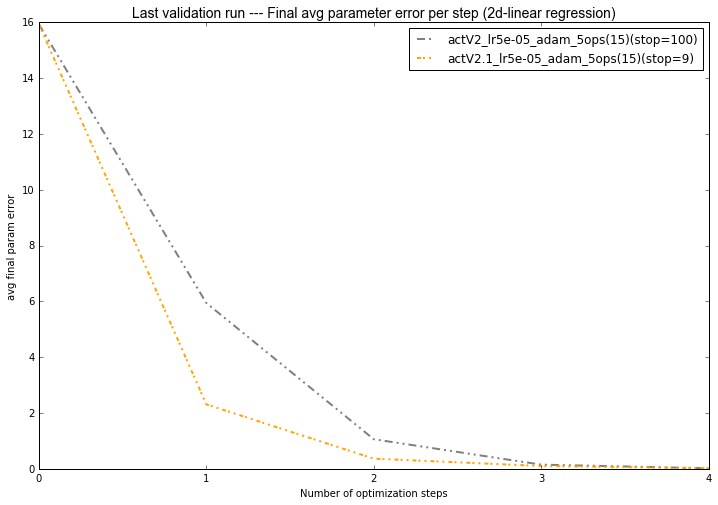

In [42]:
# new_exp_only = [experiments[0], experiments[2], experiments[4]]
best_val_runs, lowest_value = plot_val_result(experiments, do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              fig_name="lreg3_val_10000_compare_actV2_models_param_error", 
                                              loss_type="param_error",
                                              max_step=5,
                                              sort_exper="2d-linear regression",
                                              log_scale=False)

2
model: metaV1_lr5e-05_adam_5ops best val run 3 = 0.0010 / step 93
model: actV2.1_lr5e-05_adam_5ops best val run 3 = 0.0010 / step 13


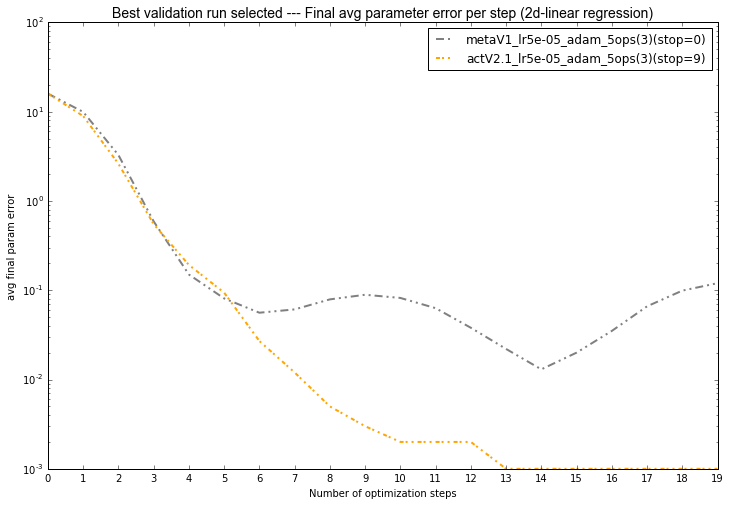

In [12]:
print(len(experiments))
best_val_runs, lowest_value = plot_val_result(experiments, do_show=True, 
                                              do_save=False, 
                                              plot_best=True,
                                              fig_name="lreg3_val_10000_compare_models", 
                                              loss_type="param_error",
                                              max_step=20,
                                              sort_exper="2d-linear regression",
                                              log_scale=True)

INFO - Successfully saved fig figures/exp3_compare_actV2_param_error_validation_09_17_32.png


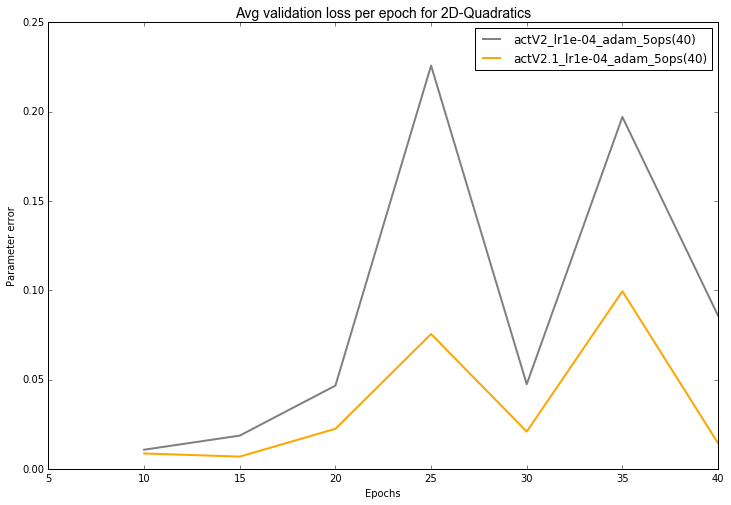

In [44]:
# exp_error_curves = [experiments[0],  experiments[3]]
plot_exper_losses(experiments, loss_type="param_error", offset=2, N=1, 
                  do_save=True, 
                  fig_name="exp3_compare_actV2_param_error_validation",
                  validation=True)


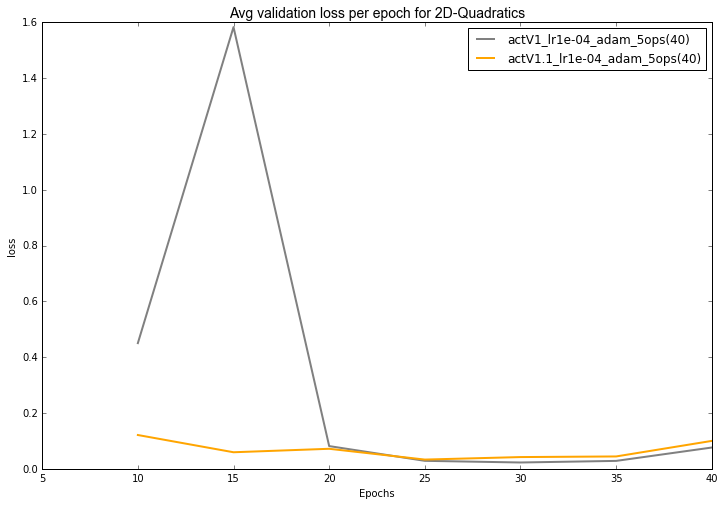

In [57]:
plot_exper_losses(exp_error_curves, loss_type="loss", offset=2, N=3, do_save=False, 
                  fig_name="param_error_curves", validation=True)


INFO - Successfully saved fig figures/expv5_val_results_1000_loss_10ops_12_01_09.png


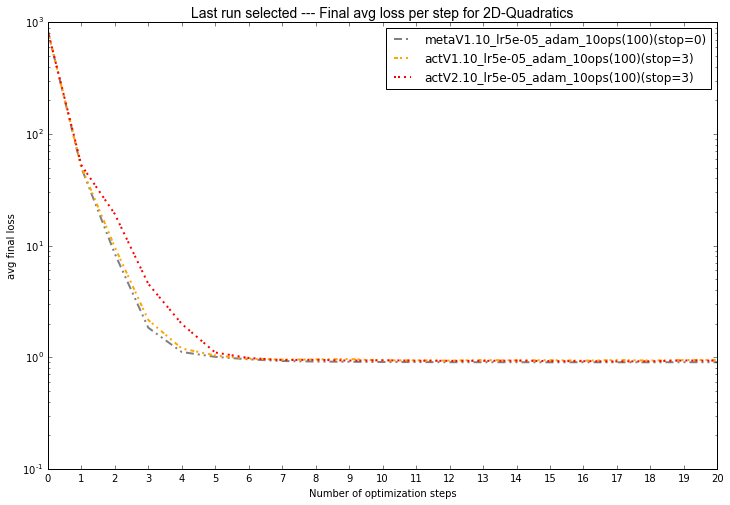

In [27]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [16]:
print(new_experiments[1].val_avg_num_opt_steps)

3


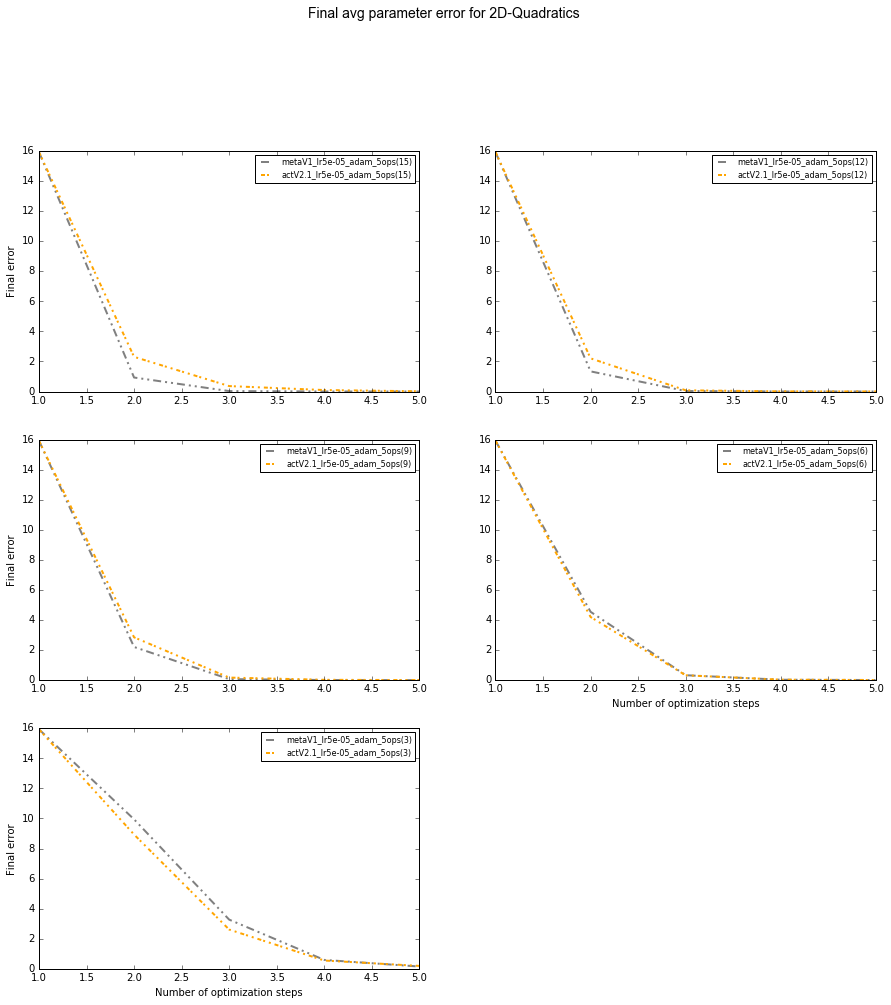

In [23]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=0, do_show=True, 
                     do_save=False, loss_type="param_error", log_scale=False, max_step=5,
                    fig_name="exp5_val_results_100_10ops_param_error_per_val_run")

In [12]:
"""
    Create some new validation functions
"""
num_of_val_funcs = 2000
val_funcs = [Quadratic2D() for i in range(num_of_val_funcs)]


In [21]:
with open("data/val_funcs_1000.dll", 'rb') as f:
    val_funcs = dill.load(f)
print("Success")

Success


INFO - -----------------------------------------------------------
INFO - INFO - Epoch 200: Validating model actV1.10_lr5e-05_adam_10ops with 1000 functions


3
Validating model actV1.10_lr5e-05_adam_10ops
INFO - Successfully saved fig logs/run_20170425_09_29_36_actV1.10_80ep_10ops_lr5e05_adam/figures/200_f200_actV1.10_80ep_10ops_12:04:51_2st.png


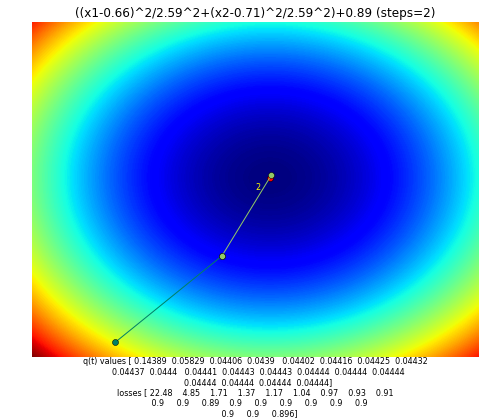

INFO - Successfully saved fig logs/run_20170425_09_29_36_actV1.10_80ep_10ops_lr5e05_adam/figures/200_f400_actV1.10_80ep_10ops_12:05:04_2st.png


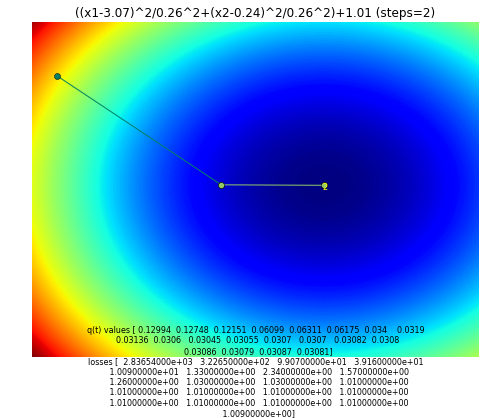

INFO - Successfully saved fig logs/run_20170425_09_29_36_actV1.10_80ep_10ops_lr5e05_adam/figures/200_f600_actV1.10_80ep_10ops_12:05:17_4st.png


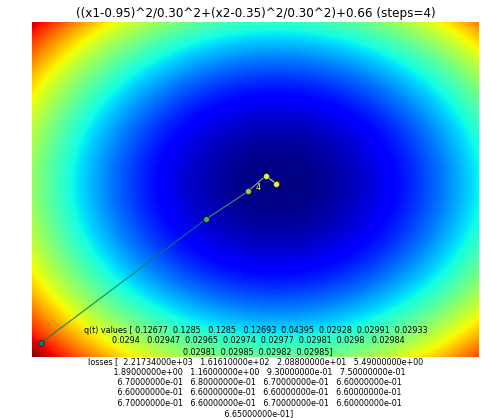

INFO - Successfully saved fig logs/run_20170425_09_29_36_actV1.10_80ep_10ops_lr5e05_adam/figures/200_f800_actV1.10_80ep_10ops_12:05:30_2st.png


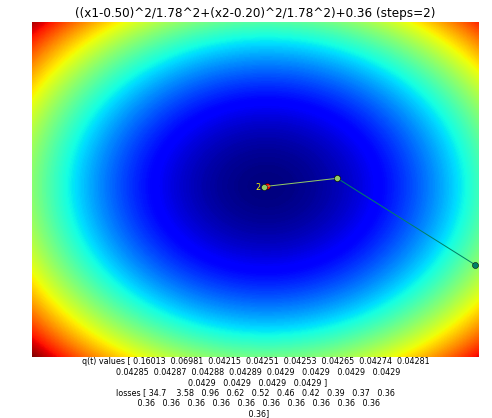

INFO - Successfully saved fig logs/run_20170425_09_29_36_actV1.10_80ep_10ops_lr5e05_adam/figures/200_f1000_actV1.10_80ep_10ops_12:05:42_3st.png


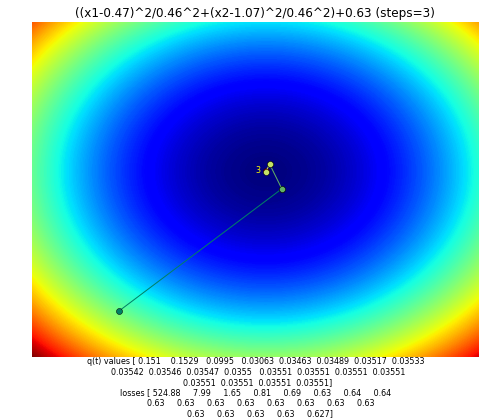

INFO - INFO - Avg number of steps: 3
INFO - INFO - Epoch 200: Final validation average loss / param-loss: 0.05206/0.002193
INFO - INFO - Epoch 200: Final step param-losses: [  5.44842000e+01   3.47840000e+00   4.18700000e-01   1.21800000e-01
   6.31000000e-02   4.33000000e-02   3.25000000e-02   2.51000000e-02
   1.98000000e-02   1.59000000e-02   1.27000000e-02   1.03000000e-02
   8.50000000e-03   7.10000000e-03   5.80000000e-03   4.90000000e-03
   4.10000000e-03   3.50000000e-03   2.90000000e-03   2.60000000e-03
   2.20000000e-03]


In [29]:
print(len(new_experiments))
exp_idx = 1
new_experiments[exp_idx].epoch = 200
model = models[exp_idx]
print("Validating model {}".format(model.name))

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=val_funcs, 
                   max_steps=20, verbose=False, plot_func=True, show_plot=True, save_plot=True,
                   num_of_plots=5)

In [42]:
exp3_1000_val_experiments = [new_experiments[1], new_experiments[3], new_experiments[5]]

In [8]:
# meta
experiments[1].val_stats["qt_hist"]

OrderedDict([(1, array([ 0.])),
             (2, array([ 0.,  0.])),
             (3, array([ 0.,  0.,  0.])),
             (4, array([ 0.,  0.,  0.,  0.])),
             (5, array([ 0.,  0.,  0.,  0.,  0.])),
             (6, array([ 0.,  0.,  0.,  0.,  0.,  0.])),
             (7, array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.])),
             (8, array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])),
             (9, array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])),
             (10, array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])),
             (11,
              array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])),
             (12,
              array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])),
             (13,
              array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])),
             (14,
              array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])),
             (15,
              arra

In [45]:
# exper = get_experiment('run_20170515_13_53_49_actV2_20ep_10ops_lr5e05_adam')
exper = get_experiment("run_20170515_14_30_31_actV2_20ep_10ops_lr5e05_adam")

In [46]:
# np.log(exper.val_stats["qt_hist"][100])
# print(len(exper.val_stats["kl_entropy"]))
exper.val_stats["kl_div"][20]

array([ -2.1202607 ,  -2.24809409,  -2.37592748,  -2.50376081,
        -2.63159421,  -2.75942762,  -2.88726094,  -3.01509436,
        -3.14292774,  -3.27076106,  -3.3985944 ,  -3.52642784,
        -3.65426122,  -3.78209454,  -3.90992789,  -4.0377613 ,
        -4.16559469,  -4.29342806,  -4.42126143,  -4.54909478,
        -4.67692815,  -4.8047615 ,  -4.93259491,  -5.06042831,
        -5.18826168,  -5.31609501,  -5.44392835,  -5.57176179,
        -5.69959511,  -5.82742849,  -5.95526184,  -6.08309524,
        -6.21092865,  -6.33876198,  -6.46659536,  -6.59442874,
        -6.72226212,  -6.8500955 ,  -6.97792884,  -7.10576222,
        -7.2335956 ,  -7.36142898,  -7.48926236,  -7.61709569,
        -7.7449291 ,  -7.87276246,  -8.00059578,  -8.12842923,
        -8.25626253,  -8.38409596,  -8.51192933,  -8.63976264,
        -8.76759607,  -8.8954294 ,  -9.02326278,  -9.15109614,
        -9.27892956,  -9.40676286,  -9.5345963 ,  -9.66242969,
        -9.790263  ,  -9.91809643, -10.04592974, -10.17

INFO - Successfully saved fig logs/run_20170515_16_05_43_actV2_15ep_5ops_lr5e05_adam/kl_parts__val_actV2_15ep_5ops.png


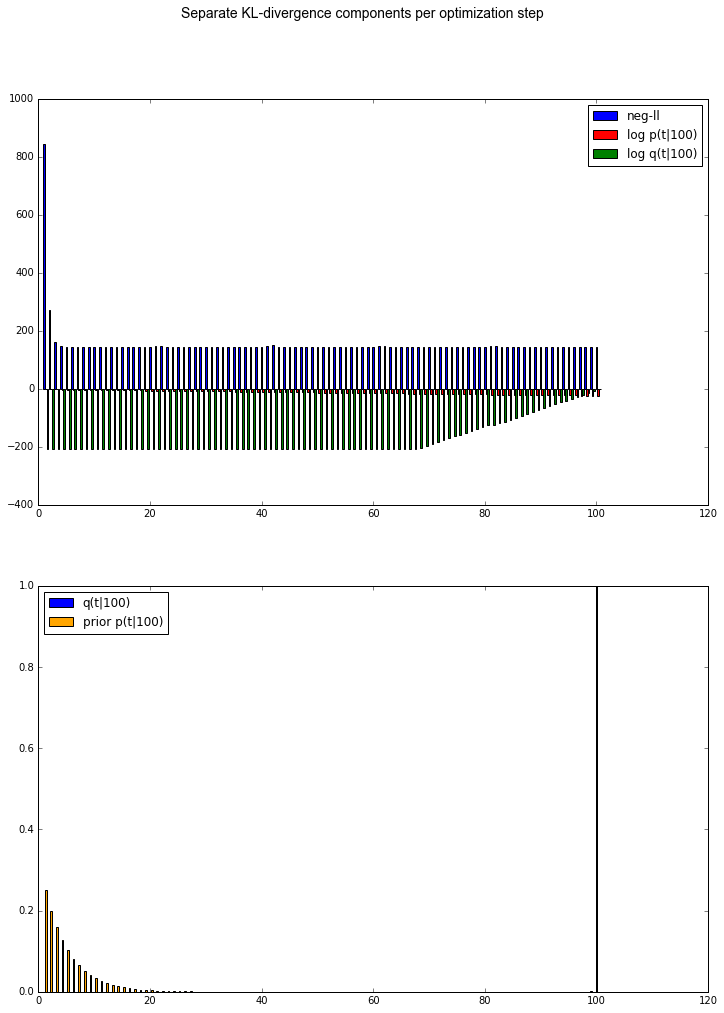

In [66]:
plot_kl_div_parts(experiments[0], save=True, show=True, final_terms=False, log_qt=True, plot_prior=True)

INFO - Successfully saved fig logs/run_20170515_16_14_13_actV2.1_15ep_5ops_lr5e05_adam/qt_T_dist_val_actV2.1_15ep_5ops.png


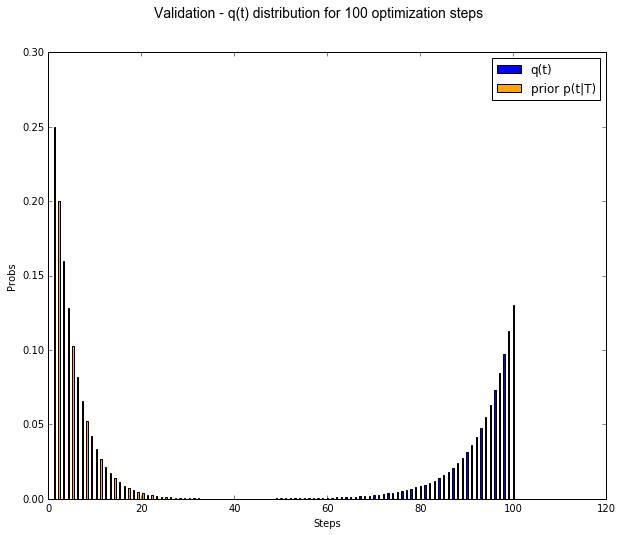

In [49]:
plot_qt_probs(experiments[1], data_set="val", save=True, show=True, plot_prior=True, height=8, width=15)